# Forecasting the level of average wages in Russia

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import warnings
%pylab inline
from itertools import product
import plotly
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

Populating the interactive namespace from numpy and matplotlib


Загрузим данные с росстата за промежуток 1991 - 2021:

In [2]:
data = pd.read_csv('AMS_Russia', index_col=['month'], parse_dates=['month'])
data.iplot(xTitle='Month',yTitle='Wage, ₽',title='Average monthly salary in Russia')

Построим декомпозицию ради интереса и убедимся в нестационарности ряда:

Критерий Дики-Фуллера: p=0.999040


<Figure size 1080x720 with 0 Axes>

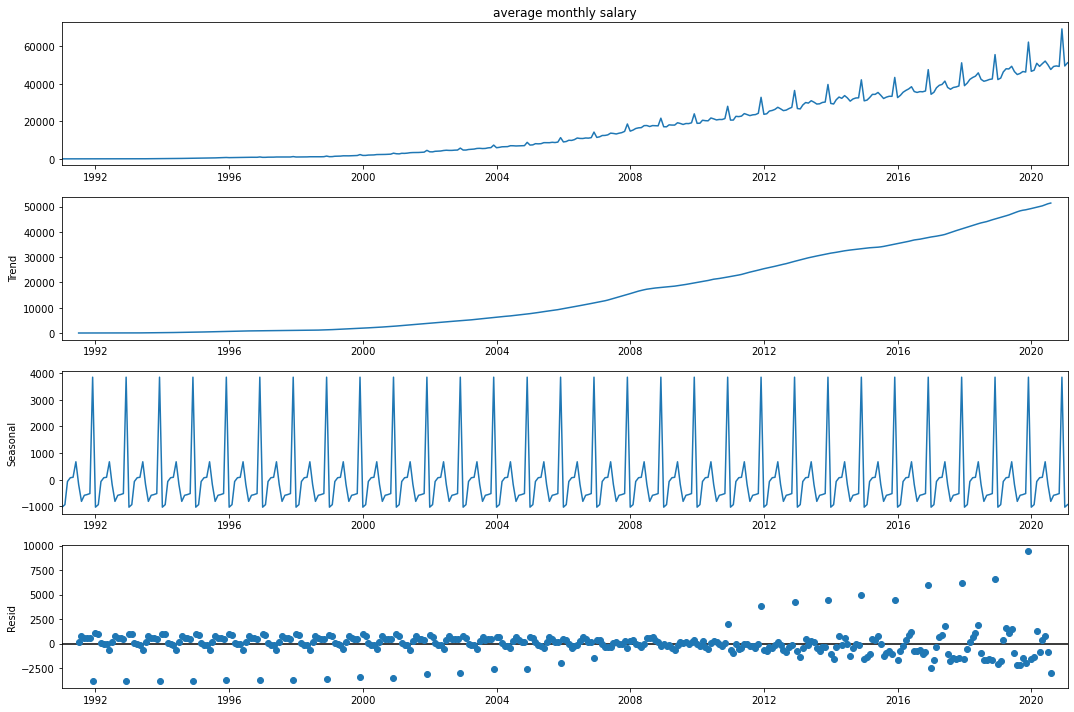

In [3]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data['average monthly salary']).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['average monthly salary'])[1])

Проведем преобразование Бокса-Кокса, чтобы стабилизировать дисперсию:

In [4]:
data['AMS_box'], lmbda = stats.boxcox(data['average monthly salary'])
data.AMS_box.iplot(xTitle='Month', yTitle='Transformed AMS', title='AMS after box-cox')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.AMS_box)[1])

Оптимальный параметр преобразования Бокса-Кокса: 0.274655
Критерий Дики-Фуллера: p=0.088375


Ряд попрежнему нестационарен. Продифференцируем сезонно:

In [5]:
data['AMS_box'].diff(12).iplot(xTitle='Month',
                               yTitle='Transformed AMS season diff', title='AMS after box-cox season diff')
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.AMS_box.diff(12).dropna())[1])

Критерий Дики-Фуллера: p=0.045401


Полученное p-value устраивает критерий Дики-Фуллера, но нас нет. Сделаем простое дифференцирование:

In [6]:
data['AMS_box'].diff(12).diff().iplot(xTitle='Month',
                                      yTitle='Transformed AMS twice diff', title='AMS after box-cox twice diff')
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.AMS_box.diff(12).diff().dropna())[1])

Критерий Дики-Фуллера: p=0.000203


Одобрено, запишем ряд в новую колонку df:

In [7]:
data['stationary'] = data.AMS_box.diff(12).diff()

Напишем функцию для автоотрисовки частичной и обычной автокорелляций:

Критерий Стьюдента: p=0.969788
Критерий Дики-Фуллера: p=0.000203


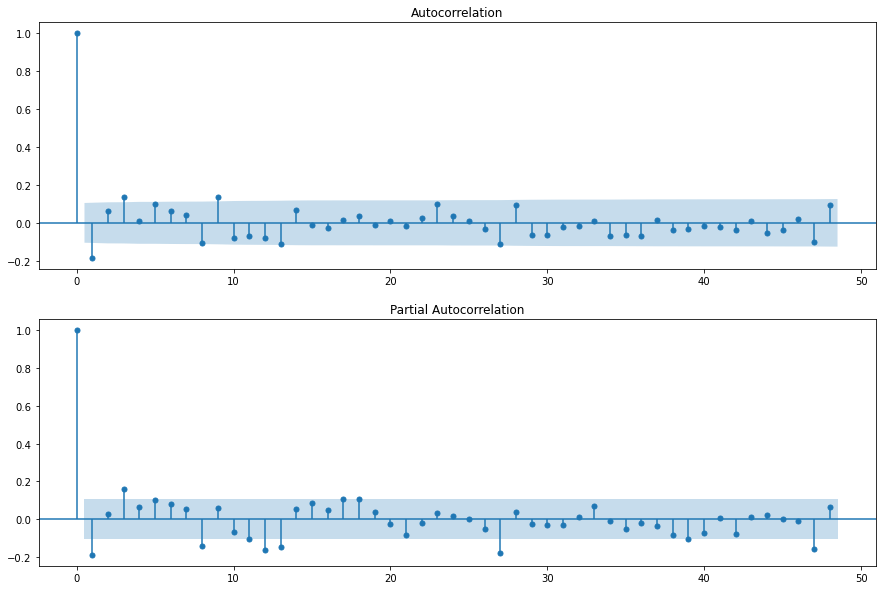

In [8]:
def q_Q_p_P(row, lags=48):
    row = row.dropna()
    plt.figure(figsize(15,10))
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(row.values.squeeze(), lags=lags, ax=ax)
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(row.values.squeeze(), lags=lags, ax=ax)
    print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(row, 0)[1])
    print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(row)[1])
    
q_Q_p_P(data.stationary)    

Находим параметры:

$$Q = 0,\;q = 9,\;P = 1,\;p = 11,\;D = 1,\;d = 1.$$

In [9]:
Qs = range(0, 2)
qs = range(0, 10)
Ps = range(0, 2)
ps = range(0, 12)
d = 1
D = 1

parameters = list(product(ps, qs, Ps, Qs))
len(parameters)

480

Запускаем обучение:

In [10]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.AMS_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 19min 16s


In [31]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']

for i in range(len(result_table)):
    k = 0
    for j in range(4):
        k += result_table.parameters[i][j]
    result_table.loc[i, 'sum_params'] = k

In [32]:
result_table.sort_values('aic').head(10)

,parameters,aic,sum_params
436,"(10, 9, 0, 0)",94.255854,19.0
199,"(4, 9, 1, 1)",96.902354,15.0
343,"(8, 5, 1, 1)",98.003410,15.0
391,"(9, 7, 1, 1)",98.233694,18.0
239,"(5, 9, 1, 1)",98.235127,16.0
437,"(10, 9, 0, 1)",98.472788,20.0
476,"(11, 9, 0, 0)",98.504529,20.0
303,"(7, 5, 1, 1)",98.606057,14.0
419,"(10, 4, 1, 1)",98.958507,16.0
477,"(11, 9, 0, 1)",99.133665,21.0


У второй модели в списке параметров меньше, но нас и первая устраивает.

In [33]:
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              AMS_box   No. Observations:                  362
Model:             SARIMAX(10, 1, 9)x(0, 1, [], 12)   Log Likelihood                 -27.128
Date:                              Fri, 30 Apr 2021   AIC                             94.256
Time:                                      12:29:14   BIC                            171.357
Sample:                                  01-01-1991   HQIC                           124.948
                                       - 02-01-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9404      0.116      8.100      0.000       0.713       1.168
ar.L2         -0.44

Графики по остаткам выбранной (лучшей) модели:

Критерий Стьюдента: p=0.934275
Критерий Дики-Фуллера: p=0.000000


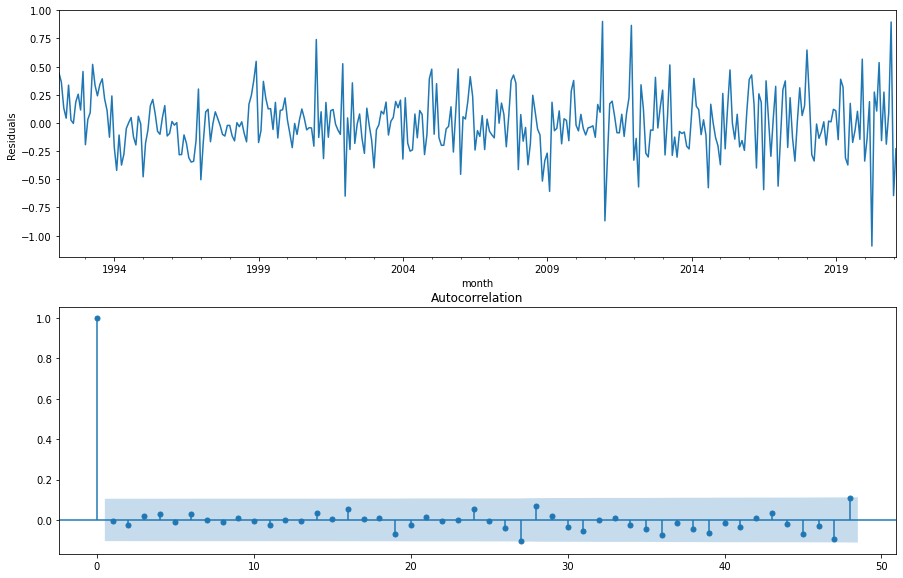

In [34]:
plt.figure(figsize(15,10))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Абсолютный шум.

Вспоминаем что такое преобразование Бокса-Кокса и делаем обратное:

In [35]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [36]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
data[['average monthly salary', 'model']].iplot(xTitle='Month', yTitle='Wage, ₽', title='Salary history')

Модель довольно таки близка к данным. Делаем предсказание на 3 года вперед для наглядности:

In [37]:
date_list = [datetime.datetime.strptime("2021-03-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]

history = data[['average monthly salary']]
future = pd.DataFrame(index = date_list, columns = history.columns)
history = pd.concat([history, future])
history['forecast'] = invboxcox(best_model.predict(start=361, end=400), lmbda)
history[['average monthly salary', 'forecast']].iplot(xTitle='Month', yTitle='Wage, ₽',
                                                      title='Salary prediction')

# Analysis of the relationship between average wages and inflation

Для интереса найдем у росстата данные по инфляции:

In [38]:
inf = pd.read_csv('russia.index.cpi.csv')
inf.set_index('Год', inplace=True)
inf

,Январь,Февраль,Март,Апрель,Май,Июнь,Июль,Август,Сентябрь,Октябрь,Ноябрь,Декабрь
Год,,,,,,,,,,,,
1991,106.20,104.80,106.30,163.50,103.00,101.20,100.60,100.50,101.10,103.50,108.90,112.10
1992,345.30,138.00,129.90,121.70,111.90,119.10,110.60,108.60,111.50,122.90,126.10,125.20
1993,125.80,124.70,120.10,118.70,118.10,119.90,122.39,126.00,123.00,119.50,116.39,112.50
1994,117.90,110.82,107.41,108.49,106.91,106.00,105.33,104.62,107.96,115.00,114.61,116.44
1995,117.77,111.02,108.94,108.47,107.93,106.66,105.38,104.56,104.46,104.72,104.56,103.20
1996,104.11,102.79,102.80,102.16,101.60,101.17,100.72,99.79,100.33,101.20,101.88,101.42
1997,102.34,101.54,101.43,100.96,100.94,101.10,100.93,99.86,99.70,100.17,100.61,100.96
1998,101.51,100.89,100.64,100.38,100.50,100.08,100.17,103.67,138.43,104.54,105.67,111.61
1999,108.38,104.13,102.79,103.03,102.22,101.91,102.82,101.16,101.48,101.37,101.23,101.26


In [39]:
date_list = [datetime.datetime.strptime("1991-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0, 31*12)]
inflation = pd.DataFrame(date_list)

for i in inf.index:
    inflation.loc[inflation[0].dt.year==i, 'rate'] = inf[inf.index==i].values[0]

inflation.dropna(inplace=True)
inflation.set_index(0, inplace=True)
inflation.rate /= 100

In [40]:
inflation[inflation.index.year>1999].rate.iplot(xTitle='Month', yTitle='Monthly ratio', title='Inflation in Russia')

Пересчитаем абсолютную инфляцию относительно 2020. Теперь график показывает обесценивание валюты.

In [41]:
inflation['cumul'] = 0.
k = 1
for i in range(len(inflation.rate)-2, -1, -1):  
    inflation.cumul[i] = k
    k /= inflation.rate[i]

In [42]:
inflation.cumul[:-1].iplot(xTitle='Month',
                    yTitle='Relation', title='Absolute change inflation from 2021-02-01')

Разделив исходные данные по з\п на абсолютную инфляцию получаем скорректированные з\п по меркам начала 2021 с неизменной ценой товаров и услуг. Это значит, что при нынешней цене продуктов россияне из 2000 получали среднюю зарплату в 12500 ₽. Кажется, что росстат где-то не договаривает.

С другой стороны, это может быть связано с повышением уплаты налогов, ведь если не платить налоги на доход, то росстат даже близко не узнает об истинном денежном обороте в стране.

In [43]:
(data['average monthly salary']/inflation.cumul[:-1]).iplot(xTitle='Month',
                                yTitle='Salary, ₽', title='Salary adjusted for inflation')

# Analysis of the relationship between average wages and food product inflation

Проведем аналогичную операцию с ценами на продовольственную продукцию. Ведь считается, что в отличие от полной инфляции, инфляция продовольственной продукции гораздо выше.

In [44]:
prod = pd.read_excel('i_prod_1991-2021.xlsx', header=3)[1:13].drop('Unnamed: 0', 1)
prod

,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
1,104.6,405.10,129.00,121.00,121.05,103.95,103.05,102.07,110.30,102.17,...,100.76,101.76,101.02,105.66,101.19,100.85,100.50,101.27,100.69,101.01
2,103.1,129.80,124.78,110.60,110.27,102.40,101.42,101.22,104.37,100.46,...,100.68,100.81,101.18,103.29,100.68,100.20,100.35,100.79,100.57,101.22
3,105.2,123.00,118.30,105.80,108.46,102.92,101.42,100.72,102.79,100.09,...,100.81,100.41,101.76,101.57,100.40,100.14,100.53,100.53,100.96,100.82
4,171.8,116.11,116.10,105.60,107.52,101.84,100.98,100.32,102.57,100.30,...,100.23,100.70,101.29,100.33,100.42,100.60,100.43,100.43,101.72,NaN
5,100.5,110.70,116.20,106.80,108.83,101.66,100.81,100.58,102.01,102.17,...,100.56,100.95,101.45,100.07,100.37,100.59,99.94,100.41,100.16,NaN
6,99.7,120.00,122.70,105.60,107.56,101.20,101.47,99.98,101.72,103.26,...,101.61,100.50,100.69,99.55,100.12,101.02,100.38,99.52,100.17,NaN
7,97.2,108.90,122.51,103.80,104.47,100.21,100.79,99.90,103.18,101.75,...,101.11,99.95,99.94,99.73,99.96,99.03,99.67,99.70,99.93,NaN
8,96.6,107.49,122.57,102.69,102.72,98.31,99.14,102.39,100.45,100.29,...,99.48,99.25,99.74,99.34,99.41,98.20,99.62,99.09,99.23,NaN
9,98.1,112.80,123.70,106.90,102.76,99.52,98.64,139.48,100.80,100.60,...,100.14,99.98,101.00,100.42,99.86,99.29,99.92,99.56,99.59,NaN
10,102.3,124.70,118.50,115.30,103.41,100.40,99.49,103.91,100.86,102.13,...,100.53,101.11,101.17,101.04,100.78,100.38,100.55,100.18,100.62,NaN


In [45]:
date_list = [datetime.datetime.strptime("1991-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0, 31*12)]
pro = pd.DataFrame(date_list)

for i, column in enumerate(prod.columns):
    pro.loc[pro[0].dt.year==int(column), 'rate'] = prod[column].values

pro.set_index(0, inplace=True)
pro.rate /= 100 

In [46]:
pro[pro.index.year>1999].rate.iplot(xTitle='Month',
                                yTitle='Relation', title='Relative monthly change in the price of food products')

In [47]:
pro['cumul'] = 0.
k = 1
for i in range(len(pro.rate.dropna())-2, -1, -1):  
    pro.cumul[i] = k
    k /= pro.rate[i]

pro = pro.dropna()

In [48]:
pro.cumul[:-1].iplot(xTitle='Month',
                                yTitle='Relation', title='Absolute change in the price of food products from 2021-02-01')

In [49]:
(data['average monthly salary']/pro.cumul[:-1]).iplot(xTitle='Month',
                                yTitle='Salary, ₽', title='Salary adjusted for rising food prices')

Видно, что от предыдущего случая график не сильно изменился.